In [66]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn 
import numpy as np
import torch
from scipy.stats import ttest_ind

In [64]:
cpx_res = pd.read_csv('/home/teddy/local/TKG-DTI/output/ablation/tkge/COMPLEX2/test_metrics.csv')
gnn_res = pd.read_csv('/home/teddy/local/TKG-DTI/output/ablation/tkge/GNN/test_metrics.csv')
data = torch.load('/home/teddy/local/TKG-DTI/data/tkg/processed/FOLD_0/Data.pt', weights_only=False)

print('# entries (COMPLEX2):', cpx_res.shape[0])
print('# entries (GNN):', gnn_res.shape[0])

rel2int = {k:v[0] for k,v in data.edge_reltype.items()} 
int2rel = {v:'->'.join(k) for k,v in rel2int.items()}

cpx_res = cpx_res.assign(remove_relation = cpx_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))
gnn_res = gnn_res.assign(remove_relation = gnn_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))


# entries (COMPLEX2): 80
# entries (GNN): 104


In [74]:
cpx_pval = {'remove_relation':[], 'pval':[], 'tstat':[], 'nx':[], 'ny':[]} 

for rel in cpx_res.remove_relation.unique():

    x = cpx_res[cpx_res.remove_relation == 'None']['MRR'].values
    y = cpx_res[cpx_res.remove_relation == rel]['MRR'].values

    nx = len(x)
    ny = len(y)

    tstat, pval = ttest_ind(x, y, equal_var=False)

    cpx_pval['remove_relation'].append(rel)
    cpx_pval['pval'].append(pval)
    cpx_pval['tstat'].append(tstat)
    cpx_pval['nx'].append(nx)
    cpx_pval['ny'].append(ny)

cpx_pval = pd.DataFrame(cpx_pval)

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [75]:
gnn_pval = {'remove_relation':[], 'pval':[], 'tstat':[], 'nx':[], 'ny':[]}

for rel in gnn_res.remove_relation.unique():

    x = gnn_res[gnn_res.remove_relation == 'None']['MRR'].values
    y = gnn_res[gnn_res.remove_relation == rel]['MRR'].values

    nx = len(x)
    ny = len(y)

    tstat, pval = ttest_ind(x, y, equal_var=False)

    gnn_pval['remove_relation'].append(rel)
    gnn_pval['pval'].append(pval)
    gnn_pval['tstat'].append(tstat)
    gnn_pval['nx'].append(nx)
    gnn_pval['ny'].append(ny)

gnn_pval = pd.DataFrame(gnn_pval)

In [85]:
cpx_res = cpx_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()
cpx_none = cpx_res.loc[cpx_res.remove_relation == 'None']
cpx_deltas = cpx_res[['MRR', 'avg_AUC', 'Top1', 'Top3']] - cpx_none[['MRR', 'avg_AUC', 'Top1', 'Top3']].values
cpx_deltas.columns = [f'{c}_delta' for c in cpx_deltas.columns]
cpx_res = pd.concat([cpx_res, cpx_deltas], axis=1)
cpx_res = cpx_res.merge(cpx_pval, on='remove_relation', how='left')

gnn_res = gnn_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()
gnn_none = gnn_res.loc[gnn_res.remove_relation == 'None']
gnn_deltas = gnn_res[['MRR', 'avg_AUC', 'Top1', 'Top3']] - gnn_none[['MRR', 'avg_AUC', 'Top1', 'Top3']].values
gnn_deltas.columns = [f'{c}_delta' for c in gnn_deltas.columns]
gnn_res = pd.concat([gnn_res, gnn_deltas], axis=1)
gnn_res = gnn_res.merge(gnn_pval, on='remove_relation', how='left')

cpx_res = cpx_res.assign(model='COMPLEX2')
gnn_res = gnn_res.assign(model='GNN') 
res = pd.concat([cpx_res, gnn_res], axis=0)
res = res.sort_values(by='MRR', ascending=False)
res = res.assign(detrimental = res.tstat < 0)
                         
res.head()

,remove_relation,MRR,avg_AUC,Top1,Top3,MRR_delta,avg_AUC_delta,Top1_delta,Top3_delta,pval,tstat,nx,ny,model,detrimental
23,drug->predicted_weak_binding_fwd->gene,0.217350,0.973750,0.131173,0.223765,0.014479,-0.000640,0.018827,0.007099,0.070154,-3.140178,5,2,COMPLEX2,True
11,drug->HA1E_lincs_perturbation_fwd->gene,0.213994,0.972648,0.125000,0.231481,0.011123,-0.001741,0.012654,0.014815,0.017060,-3.883934,5,2,COMPLEX2,True
16,drug->PHH_lincs_perturbation_fwd->gene,0.211695,0.974598,0.114198,0.240741,0.008824,0.000208,0.001852,0.024074,NaN,NaN,5,1,COMPLEX2,False
15,drug->PC3_lincs_perturbation_fwd->gene,0.211102,0.974007,0.126543,0.228395,0.008231,-0.000382,0.014198,0.011728,0.368254,-1.260815,5,2,COMPLEX2,True
41,gene->predicted_conf_weak_binding_rev->drug,0.209924,0.981145,0.114198,0.234568,0.007053,0.006755,0.001852,0.017901,NaN,NaN,5,1,COMPLEX2,False


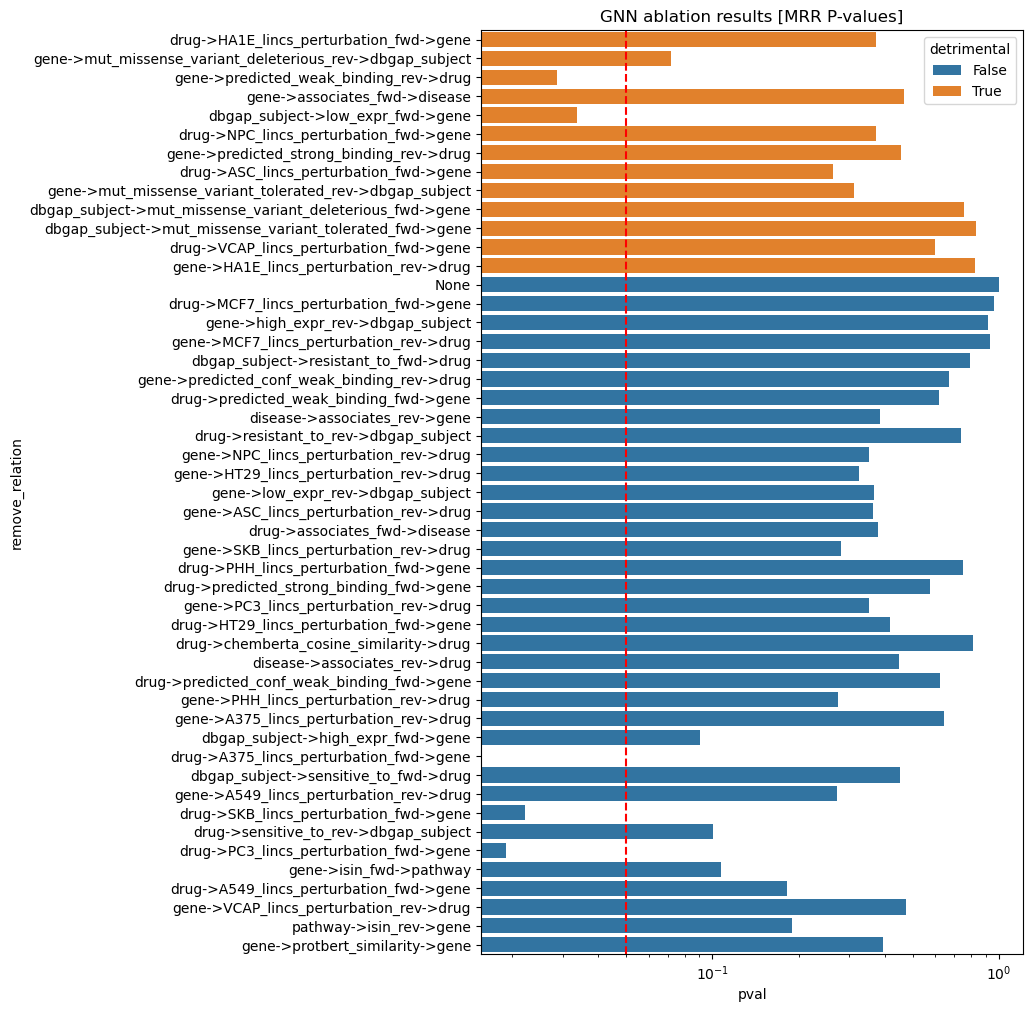

In [95]:
plt.figure(figsize=(7,12)) 
#sbn.barplot(x='avg_AUC_delta', y='remove_relation', data=res[lambda x: x.model == 'GNN'].sort_values(by='avg_AUC_delta', ascending=False).reset_index())
sbn.barplot(x='pval', y='remove_relation', hue='detrimental', data=res[lambda x: x.model == 'GNN'].reset_index())
plt.xscale('log')
plt.axvline(0.05, color='red', linestyle='--', label='0.05')
plt.title('GNN ablation results [MRR P-values]')
plt.show()

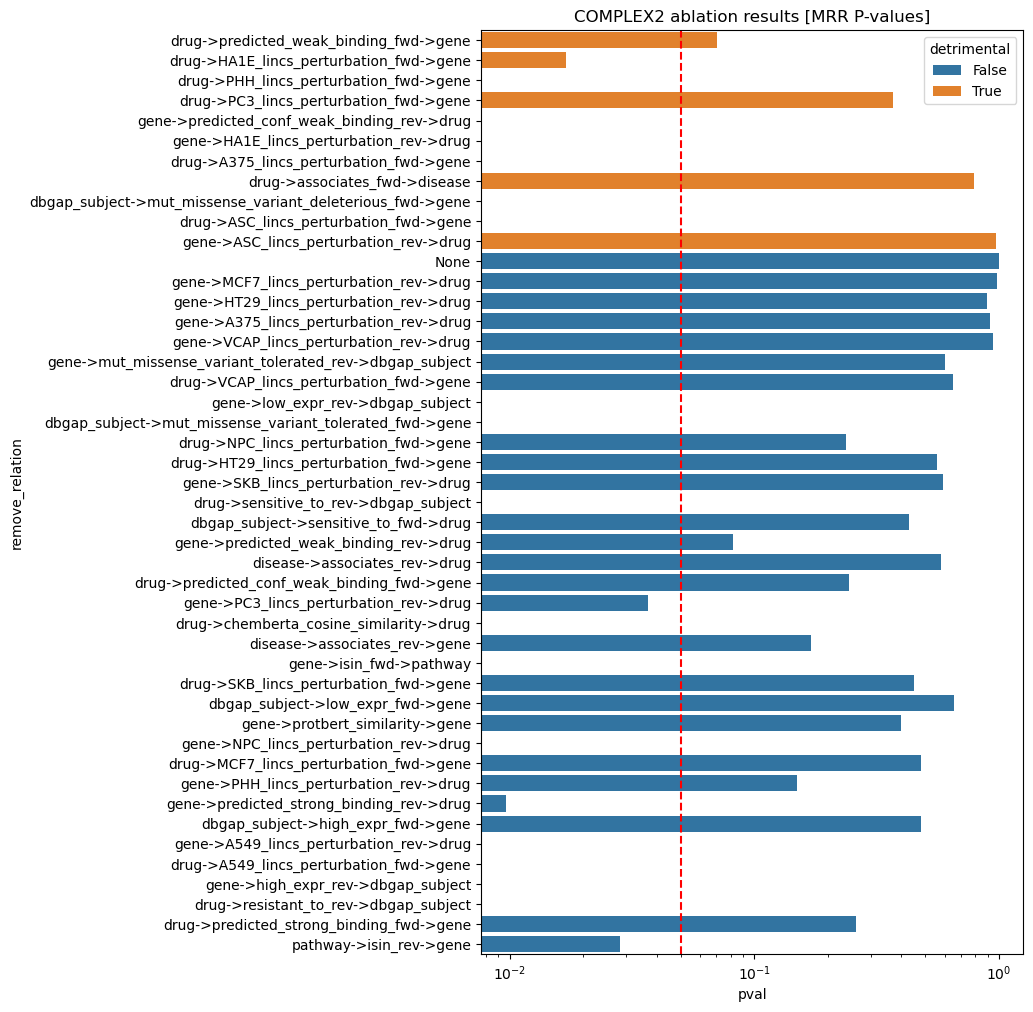

In [96]:
plt.figure(figsize=(7,12)) 
#sbn.barplot(x='avg_AUC_delta', y='remove_relation', data=res[lambda x: x.model == 'GNN'].sort_values(by='avg_AUC_delta', ascending=False).reset_index())
sbn.barplot(x='pval', y='remove_relation', hue='detrimental', data=res[lambda x: x.model == 'COMPLEX2'].reset_index())
plt.xscale('log')
plt.axvline(0.05, color='red', linestyle='--')
plt.title('COMPLEX2 ablation results [MRR P-values]')
plt.show()

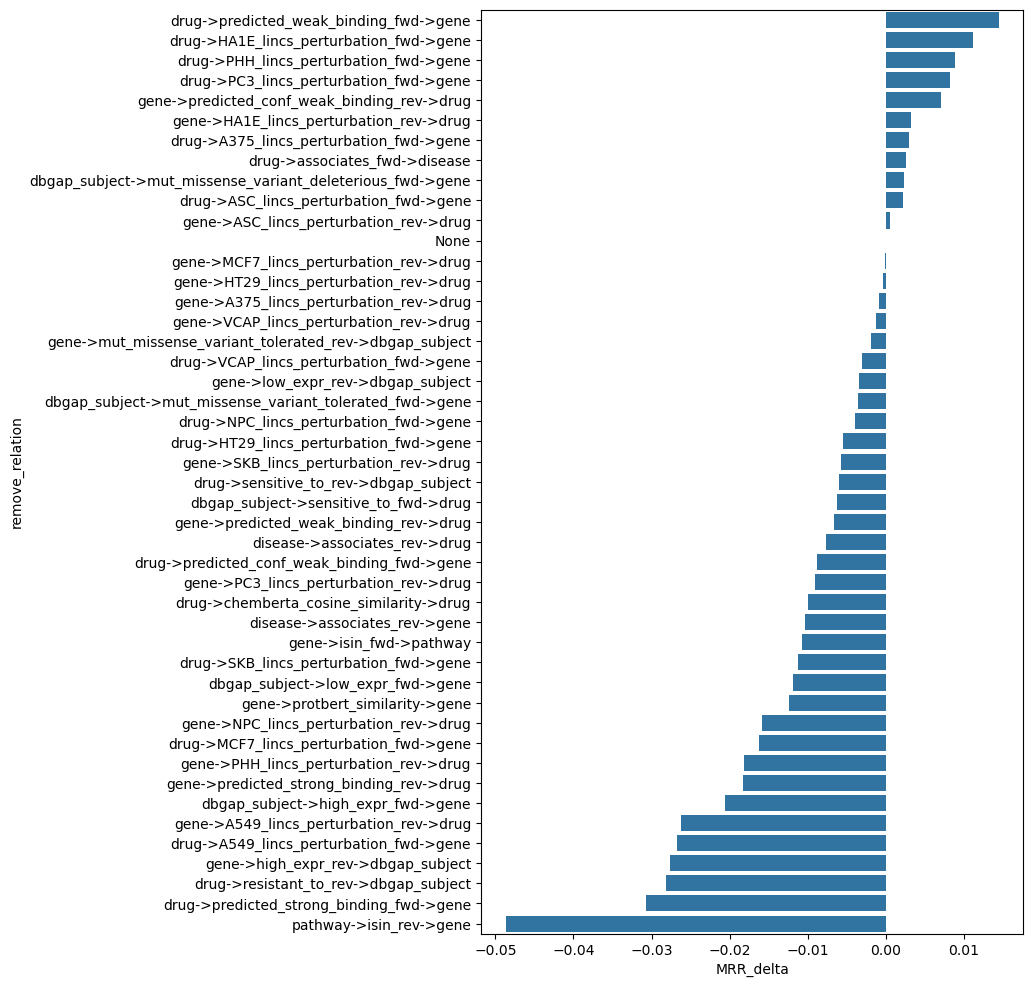

In [17]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x='MRR_delta', y='remove_relation', data=res[lambda x: x.model == 'COMPLEX2'])
plt.show()

In [57]:
res_wide = res.pivot(index='remove_relation', columns='model', values='MRR_delta')
res_wide = res_wide.assign(avg=res_wide.mean(axis=1))
res_wide = res_wide.sort_values(by='avg', ascending=False)
res_wide.head(15)

model,COMPLEX2,GNN,avg
remove_relation,,,
gene->mut_missense_variant_deleterious_rev->dbgap_subject,NaN,0.015111,0.015111
gene->associates_fwd->disease,NaN,0.013311,0.013311
drug->HA1E_lincs_perturbation_fwd->gene,0.011123,0.015385,0.013254
drug->predicted_weak_binding_fwd->gene,0.014479,-0.004091,0.005194
drug->ASC_lincs_perturbation_fwd->gene,0.002161,0.005668,0.003914
gene->predicted_weak_binding_rev->drug,-0.006573,0.013872,0.003649
dbgap_subject->mut_missense_variant_deleterious_fwd->gene,0.002356,0.003126,0.002741
gene->predicted_conf_weak_binding_rev->drug,0.007053,-0.002046,0.002504
gene->HA1E_lincs_perturbation_rev->drug,0.003289,0.001108,0.002198


In [42]:
res_wide.tail(20)

model,COMPLEX2,GNN,avg
remove_relation,,,
disease->associates_rev->drug,-0.007610,-0.009186,-0.008398
drug->MCF7_lincs_perturbation_fwd->gene,-0.016258,-0.000660,-0.008459
gene->PC3_lincs_perturbation_rev->drug,-0.009112,-0.008352,-0.008732
drug->chemberta_cosine_similarity->drug,-0.009896,-0.008414,-0.009155
drug->predicted_conf_weak_binding_fwd->gene,-0.008745,-0.010431,-0.009588
dbgap_subject->sensitive_to_fwd->drug,-0.006226,-0.013713,-0.009970
gene->NPC_lincs_perturbation_rev->drug,-0.015794,-0.004874,-0.010334
drug->sensitive_to_rev->dbgap_subject,-0.005997,-0.016716,-0.011356
gene->VCAP_lincs_perturbation_rev->drug,-0.001265,-0.024594,-0.012929


COMPLEX-GNN MRR DELTAS CORR 0.28288621646623496


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

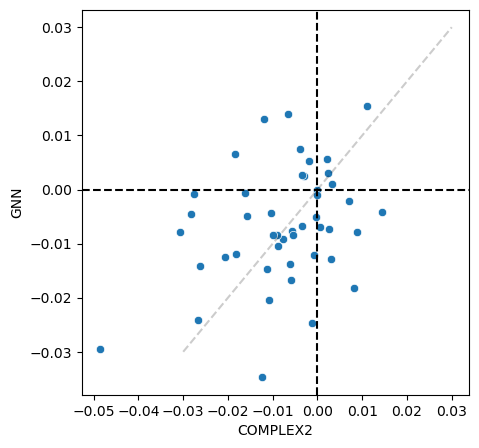

In [56]:
r = res_wide.corr(method='spearman').values[0,1]
print('COMPLEX-GNN MRR DELTAS CORR', r)

plt.figure(figsize=(5,5))
sbn.scatterplot(x='COMPLEX2', y='GNN', data=res_wide.reset_index())
plt.axvline(0, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.plot([-0.03, 0.03], [-0.03, 0.03], color='black', linestyle='--', alpha =0.2)
plt.set_title('MRR delta')
plt.show()


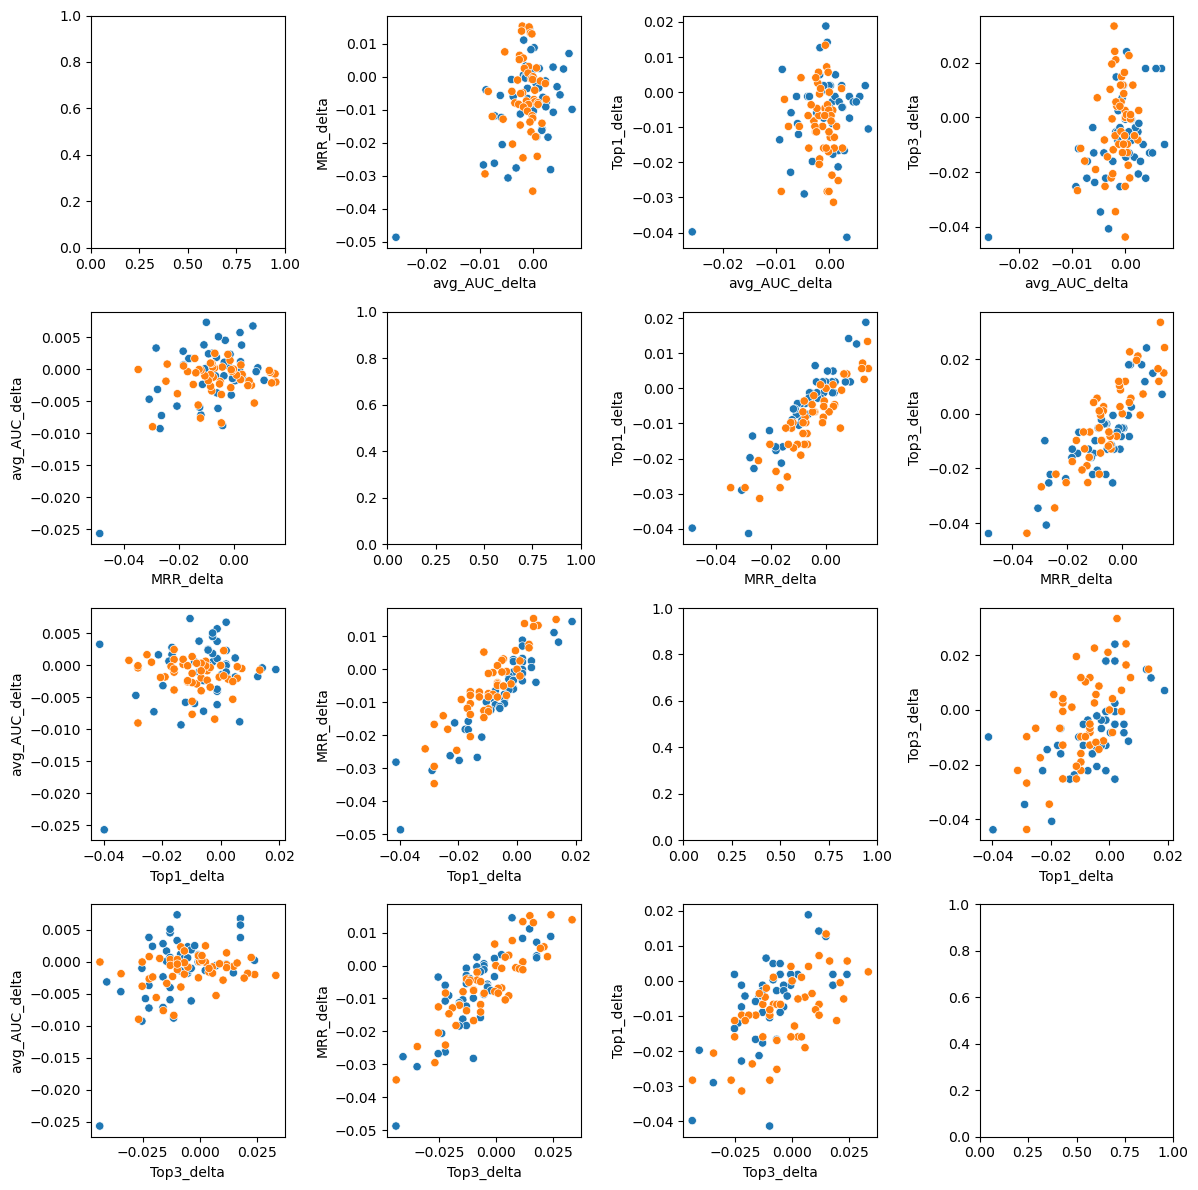

In [60]:

f,axes = plt.subplots(4,4, figsize=(12,12))


for i,xx in enumerate(['avg_AUC_delta', 'MRR_delta', 'Top1_delta', 'Top3_delta']):
    for j, yy in enumerate(['avg_AUC_delta', 'MRR_delta', 'Top1_delta', 'Top3_delta']):
        if xx == yy:
            continue

        sbn.scatterplot(x=xx, y=yy, hue='model', data=res, ax=axes[i,j], legend=False)

plt.tight_layout()
plt.show()



In [ ]:


# ttest 

# remove sig detrimental relations 

# run hparam tuning 

# prepare results for anupriya 